In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,plot_cls_correlation,identify_unreliable_group,final_mean_value
from data_split import train_test_split

In [3]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    
    return df

In [4]:
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [5]:
all_data = pd.read_csv('../data/data_processing_result/cyp_preprocessing_finished.csv')

In [6]:
all_data.head()

,Smiles_unify,Smiles,value_uM,value_uM_log,ref,source,CYP_type,property
0,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,0.02,-1.6990,CHEMBL1146077,ChEMBL,CYP2D6,cyp_IC50
1,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,6.00,0.7782,CHEMBL1140162,ChEMBL,CYP3A4,cyp_IC50
2,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,0.70,-0.1549,CHEMBL1146078,ChEMBL,CYP3A4,cyp_IC50
3,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,24.00,1.3802,CHEMBL1141628,ChEMBL,CYP2D6,cyp_IC50
4,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,2.00,0.3010,CHEMBL1138111,ChEMBL,CYP2D6,cyp_IC50


<AxesSubplot:>

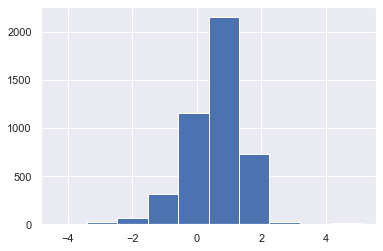

In [7]:
all_data['value_uM_log'].hist()

## Repeated values

In [8]:
controlled_value =  ['Smiles_unify','CYP_type']

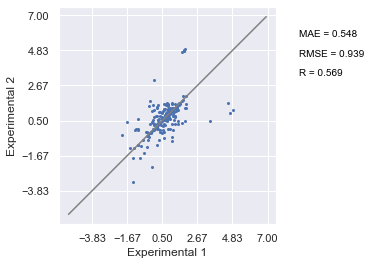

In [9]:
plot_diagram(all_data, controlled_value, 'value_uM_log')

# Further filtering

In [10]:
df_remove_bad_data = remove_bad_datapoints(all_data,controlled_value,'value_uM_log',fold=np.log10(3))

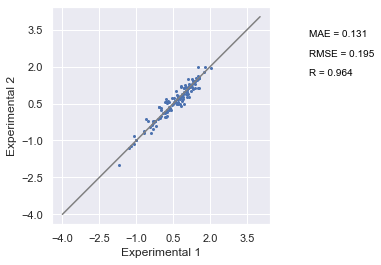

In [11]:
plot_diagram(df_remove_bad_data, controlled_value, 'value_uM_log')

In [12]:
df = final_mean_value(df_remove_bad_data,controlled_value, 'value_uM')

In [16]:
df

,Smiles_unify,Smiles,value_uM,value_uM_log,ref,source,CYP_type,property,value_uM_mean
0,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,0.0200,-1.6990,CHEMBL1146077,ChEMBL,CYP2D6,cyp_IC50,0.015333
1,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,6.0000,0.7782,CHEMBL1140162,ChEMBL,CYP3A4,cyp_IC50,6.000000
2,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,0.7000,-0.1549,CHEMBL1146078,ChEMBL,CYP3A4,cyp_IC50,0.700000
3,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,24.0000,1.3802,CHEMBL1141628,ChEMBL,CYP2D6,cyp_IC50,24.000000
4,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,2.0000,0.3010,CHEMBL1138111,ChEMBL,CYP2D6,cyp_IC50,2.000000
...,...,...,...,...,...,...,...,...,...
4502,CC1([C@@H]2COC[C@H](COC(=O)N3CCC(CO)CC3)N2S(=O...,CC1([C@@H]2COC[C@H](COC(=O)N3CCC(CO)CC3)N2S(=O...,0.0055,-2.2596,CHEMBL1268982,ChEMBL,CYP3A4,cyp_IC50,0.005500
4503,CN[C@@H]1CCc2ccccc2[C@@H]1c1ccc(Cl)c(Cl)c1,CN[C@@H]1CCc2ccccc2[C@@H]1c1ccc(Cl)c(Cl)c1,7.6000,0.8808,CHEMBL1641414,ChEMBL,CYP2C9,cyp_IC50,7.600000
4504,O=c1cc(OCc2ccccc2)ccn1-c1ccc2c(cnn2CCN2CC[C@H]...,O=c1cc(OCc2ccccc2)ccn1-c1ccc2c(cnn2CCN2CC[C@H]...,7.7000,0.8865,CHEMBL1287684,ChEMBL,CYP3A4,cyp_IC50,7.700000
4505,Cc1cc2c(cc1C)N(CC(=O)N1CCCC(c3ccccc3)C1CN1CCCC...,Cc1cc2c(cc1C)N(CC(=O)N1CCCC(c3ccccc3)C1CN1CCCC...,5.1000,0.7076,CHEMBL1145579,ChEMBL,CYP2D6,cyp_IC50,5.100000


In [17]:
df_dd = df.drop_duplicates(subset=controlled_value)
df_dd.shape

(4193, 9)

In [18]:
df_dd = df_dd[['Smiles_unify', 'value_uM_mean','CYP_type', 'property']]

In [19]:
df_dd['CYP_type'].value_counts()

CYP3A4    1980
CYP2D6    1214
CYP2C9     999
Name: CYP_type, dtype: int64

In [20]:
df_dd.columns = ['Smiles_unify', 'value','CYP_type', 'property']

In [21]:
cyp_3a4 = df_dd[df_dd['CYP_type'] == 'CYP3A4']
cyp_2d6 = df_dd[df_dd['CYP_type'] == 'CYP2D6']
cyp_2c9 = df_dd[df_dd['CYP_type'] == 'CYP2C9']

In [22]:
cyp_3a4['property'] = 'cyp_3a4'
cyp_2d6['property'] = 'cyp_2d6'
cyp_2c9['property'] = 'cyp_2c9'

In [24]:
cyp_3a4 = cyp_3a4[['Smiles_unify', 'value', 'property']]

cyp_2d6 = cyp_2d6[['Smiles_unify', 'value', 'property']]

cyp_2c9 = cyp_2c9[['Smiles_unify', 'value', 'property']]

# Compound Property analysis

In [25]:
cyp_3a4['value'] = cyp_3a4['value'].map(lambda x: min(100,x))
cyp_2d6['value'] = cyp_2d6['value'].map(lambda x: min(100,x))
cyp_2c9['value'] = cyp_2c9['value'].map(lambda x: min(100,x))

cyp_3a4


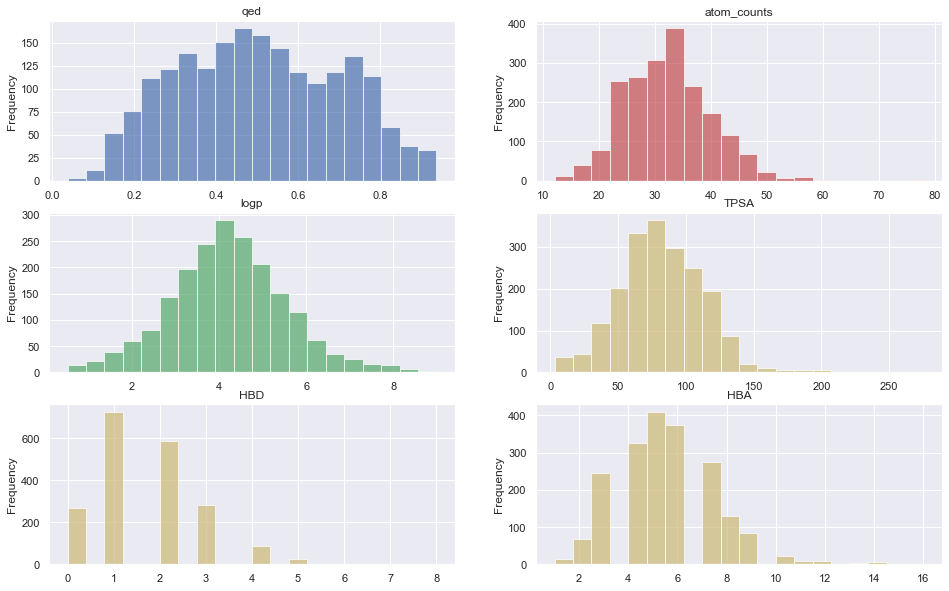

cyp_2d6


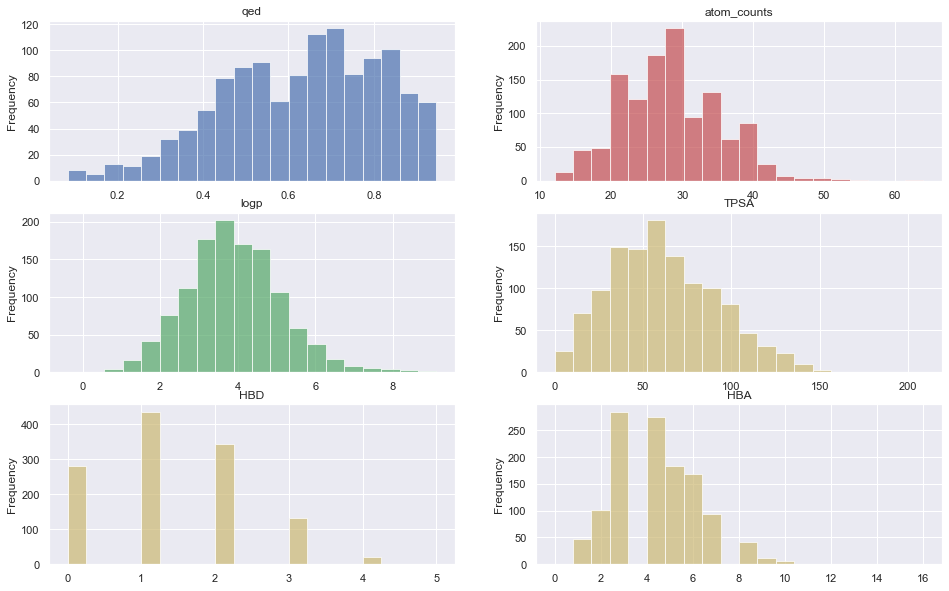

cyp_2c9


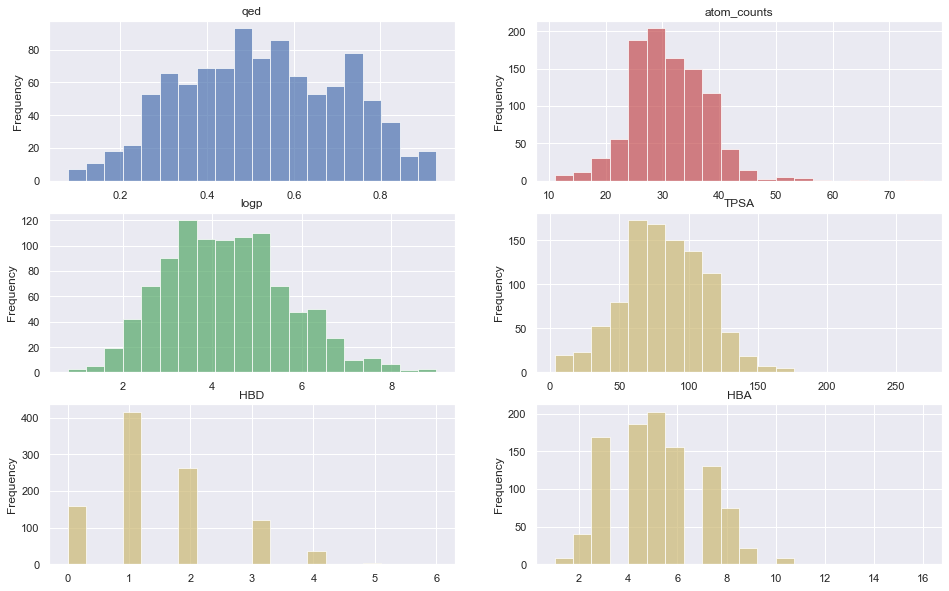

In [26]:
for df in [cyp_3a4,cyp_2d6,cyp_2c9]:
    print(df['property'].unique()[0])
    mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)
    compound_property_analysis(mol_list)

# Data Split

In [27]:
for df in [cyp_3a4,cyp_2d6,cyp_2c9]:
    df =  df.reset_index()
    train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
    df.loc[train_index,'scaffold_train_test_label'] = 'train'
    df.loc[test_index,'scaffold_train_test_label'] = 'test'
    train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
    df.loc[train_index,'random_train_test_label'] = 'train'
    df.loc[test_index,'random_train_test_label'] = 'test'
    property_name = df['property'].unique()[0]
    df.to_csv(f'../data/final_datasets/{property_name}_reg_final_data.csv',index=False)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 9035.41it/s]
